In [1]:
import torch
import matplotlib.pyplot as plt
import os
import tqdm
import time
import skimage
import trimesh
import os.path as osp
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('pythreejs')
import sys
sys.path.append('..')
from t4dt.t4dt import get_qtt_frame, qtt2tensor3d, oqtt2tensor3d, qtt_stack
from t4dt.metrics import compute_metrics, hausdorff, MSDM2
from t4dt.utils import sdf2mesh
from labellines import labelLine, labelLines
from adjustText import adjust_text
plt.style.use('ggplot')
plt.rcParams.update({
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'font.family': 'Helvetica'
})

In [2]:
ckpt1 = torch.load('../logs/sweeps/tt_tucker_00032_longshort_flying_eagle_ranks.pt')
ckpt2 = torch.load('../logs/sweeps/tt_00032_longshort_flying_eagle_ranks.pt')

In [32]:
min_tsdf, max_tsdf = -0.05, 0.05
data_dir = '/scratch2/data/cape_release/'
model = '00032'
scene = 'longshort_flying_eagle'
frames = []
for frame in sorted(os.listdir(osp.join(data_dir, 'meshes', model, scene, 'posed'))):
    if frame.startswith('sdf'):
        frames.append(frame)

In [33]:
files = [(osp.join(data_dir, 'meshes', model, scene, 'posed', frame),
              osp.join(data_dir, 'meshes', model, scene, 'posed', frame[4:-2] + 'obj'))
             for frame in frames]

In [6]:
metrics1 = {'l2': [], 'chamfer_distance': [], 'IoU': [], 'hausdorff': [], 'MSDM2': []}
metrics2 = {'l2': [], 'chamfer_distance': [], 'IoU': [], 'hausdorff': [], 'MSDM2': []}

for tucker_rank in ckpt1[(min_tsdf, max_tsdf)].keys():
    for key in metrics1.keys():
        metrics1[key].append([])
        metrics2[key].append([])
    for tt_rank in ckpt1[(min_tsdf, max_tsdf)][tucker_rank].keys():
        for key in metrics1.keys():
            metrics1[key][-1].append(
                (ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][0][key] +
                ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][142][key] +
                ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][283][key]) / 3
            )
            metrics2[key][-1].append(
                (ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][0][key] +
                ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][142][key] +
                ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][283][key]) / 3
            )

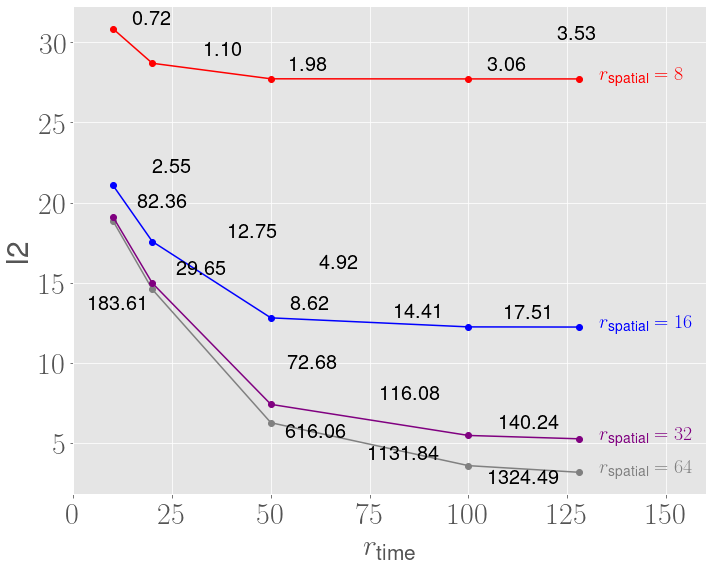

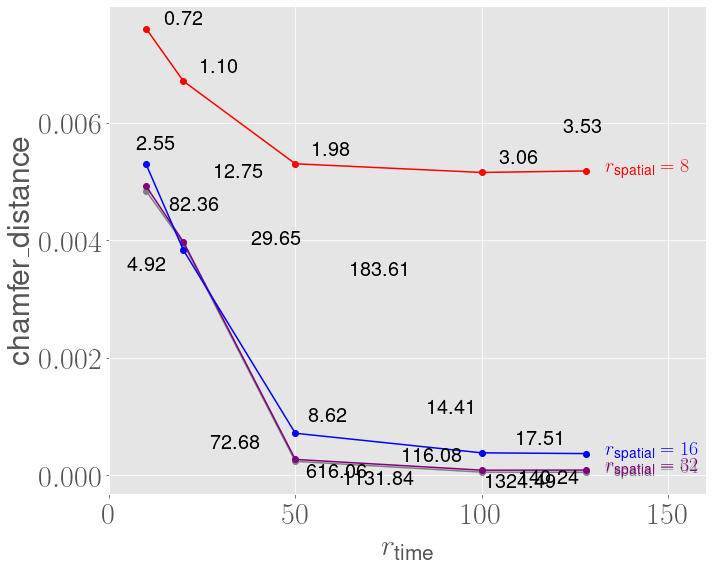

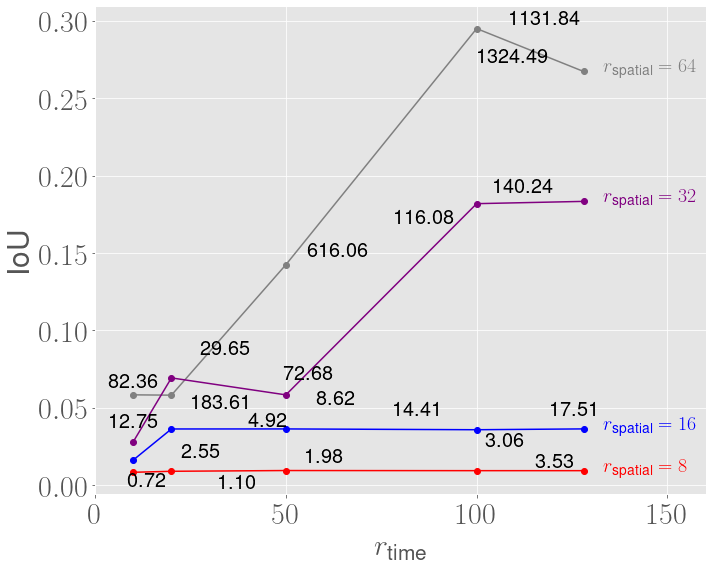

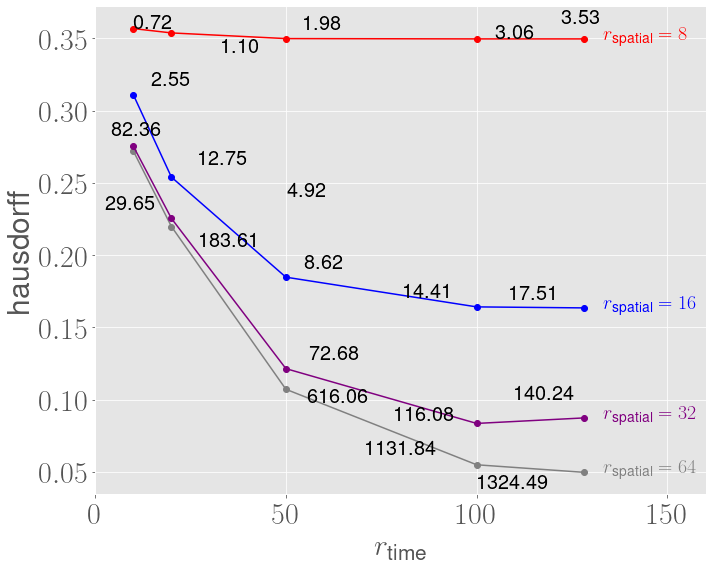

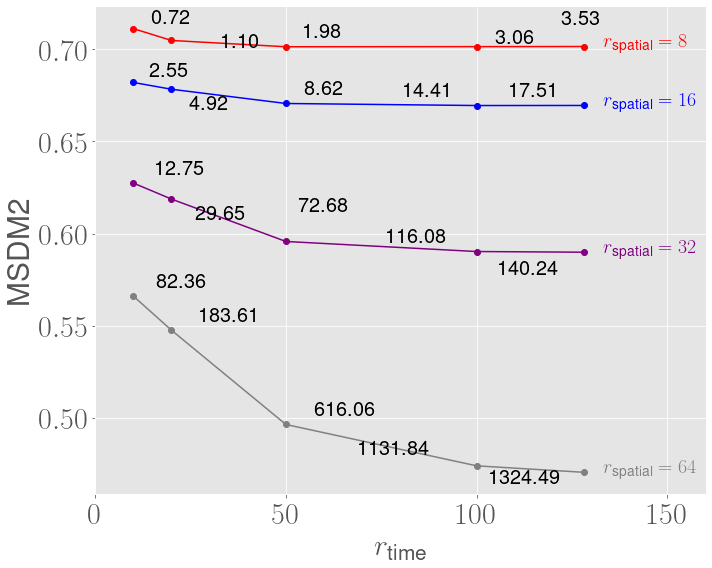

In [33]:
for key in metrics1.keys():
    fig = plt.figure(figsize=(10, 8))
    texts = []
    
    colors = ['grey', 'purple', 'blue', 'red']

    for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
        outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
        plt.plot(
            outer_ranks,
            metrics1[key][i], marker='o', color=colors[i])
#         plt.plot(
#             outer_ranks,
#             metrics2[key][i], marker='o', label=r'TT, $r_{\text{spatial}}$ ' + f'$={inner_rank}$')
        plt.text(
             outer_ranks[0] + 5,
             metrics1[key][i][0].item() if isinstance(metrics1[key][i][0], torch.Tensor) else metrics1[key][i][0],
             r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
             fontsize=20,
             color=colors[i])
        for j, k in enumerate(outer_ranks):
            t = ckpt1[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
            texts.append(
                plt.text(
                    k,
                    metrics1[key][i][j].item() if isinstance(metrics1[key][i][j], torch.Tensor) else metrics1[key][i][j],
                    f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                    fontsize=20))
#         plt.plot(ckpt2[(min_tsdf, max_tsdf)][inner_rank].keys(), metrics2[key][i], label=f'TT Inner rank: {inner_rank}')
#     plt.legend(loc='best', fontsize=20)
#     labelLines(fig.axes[0].get_lines(), yoffsets=-1, align=False, fontsize=20, zorder=50)
    plt.xlabel(r'$r_{\text{time}}$', fontsize=30)
    plt.ylabel(key, fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.tick_params(axis='both', which='minor', labelsize=30)
    adjust_text(texts,
                expand_text=(2.05, 1.5),
                expand_points=(2.05, 1.5),
                expand_objects=(2.05, 1.5),
                expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
    plt.xlim(0, 160)
    plt.tight_layout()
    plt.savefig(f'../imgs/tt_tucker_{key}.pdf')
    plt.show()

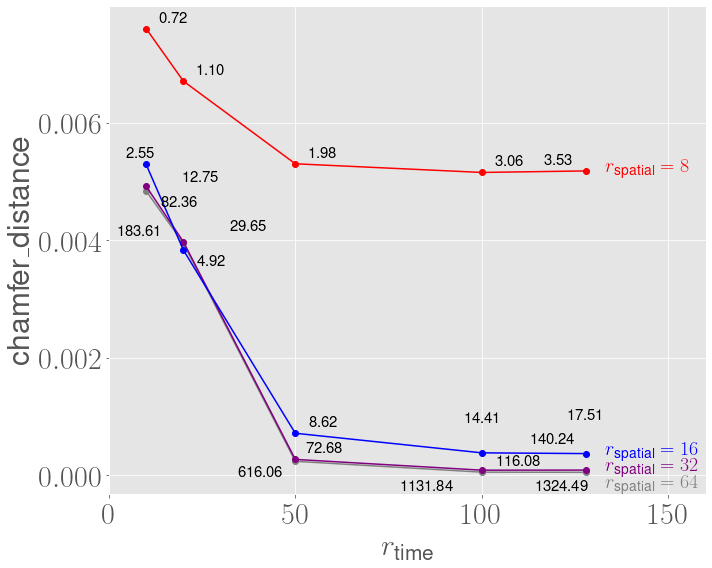

In [34]:
key = 'chamfer_distance'
fig = plt.figure(figsize=(10, 8))
texts = []

colors = ['grey', 'purple', 'blue', 'red']
offsets = [-2.5 * 1e-4, 0, 0, 0]

for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
    outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
    plt.plot(
        outer_ranks,
        metrics1[key][i], marker='o', color=colors[i])
#         plt.plot(
#             outer_ranks,
#             metrics2[key][i], marker='o', label=r'TT, $r_{\text{spatial}}$ ' + f'$={inner_rank}$')
    plt.text(
         outer_ranks[0] + 5,
         metrics1[key][i][0].item() + offsets[i],
         r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
         fontsize=20,
         color=colors[i])
    for j, k in enumerate(outer_ranks):
        t = ckpt1[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
        texts.append(
            plt.text(
                k,
                metrics1[key][i][j].item() if isinstance(metrics1[key][i][j], torch.Tensor) else metrics1[key][i][j],
                f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                fontsize=15))
#         plt.plot(ckpt2[(min_tsdf, max_tsdf)][inner_rank].keys(), metrics2[key][i], label=f'TT Inner rank: {inner_rank}')
#     plt.legend(loc='best', fontsize=20)
#     labelLines(fig.axes[0].get_lines(), yoffsets=-1, align=False, fontsize=20, zorder=50)
plt.xlabel(r'$r_{\text{time}}$', fontsize=30)
plt.ylabel(key, fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
adjust_text(texts,
            expand_text=(2.05, 1.5),
            expand_points=(2.05, 1.5),
            expand_objects=(2.05, 1.5),
            expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
plt.xlim(0, 160)
plt.tight_layout()
plt.savefig(f'../imgs/tt_tucker_{key}.pdf')
plt.show()

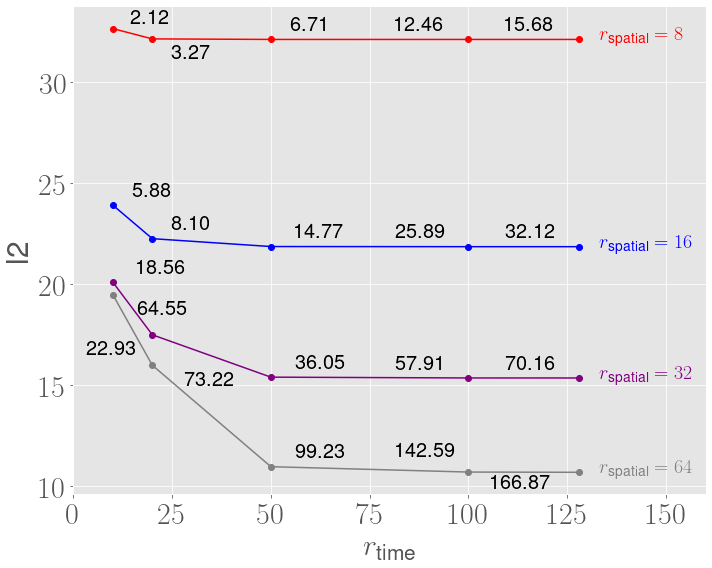

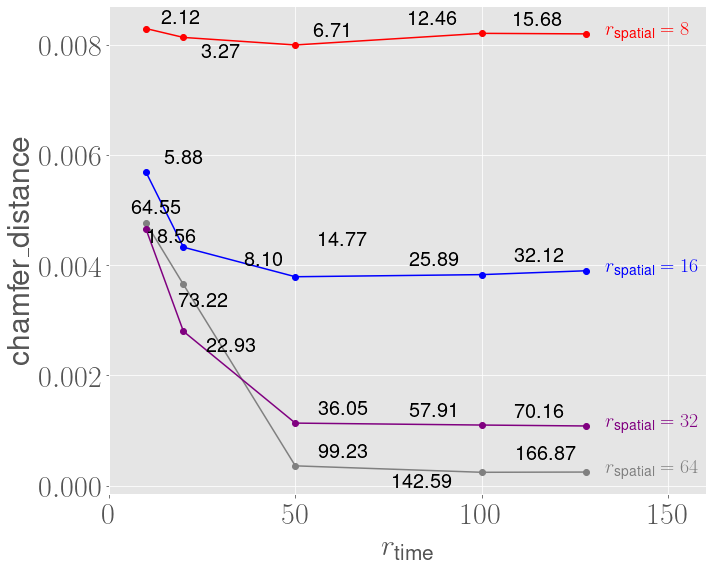

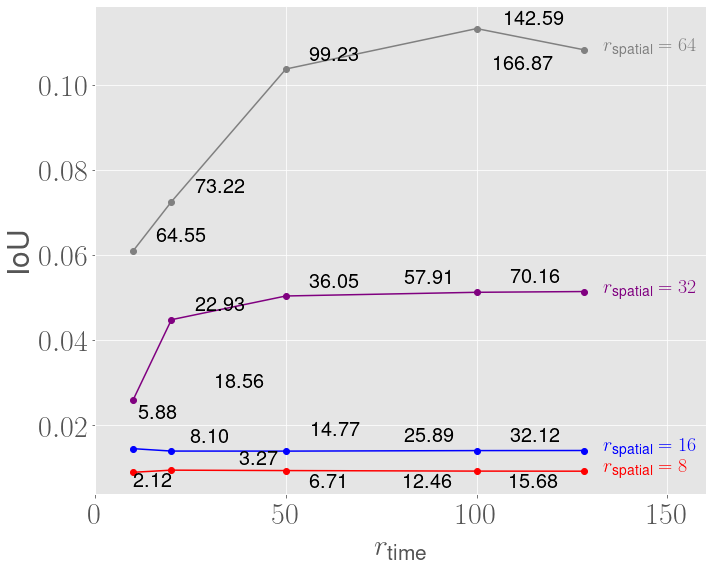

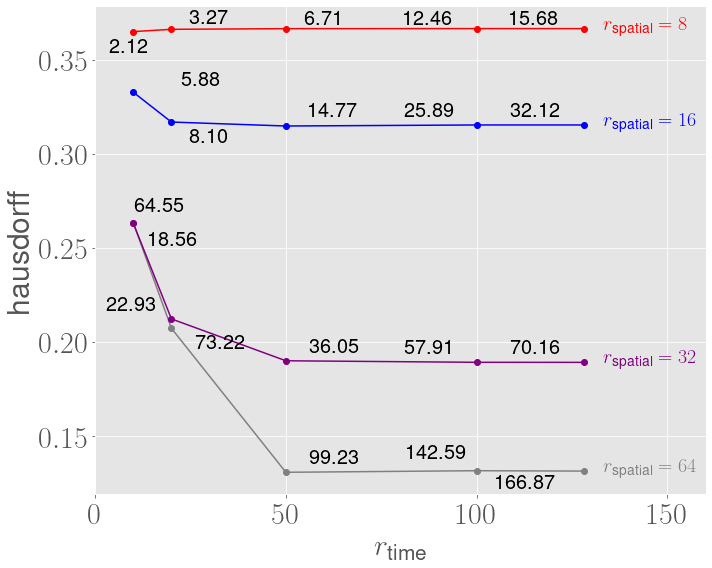

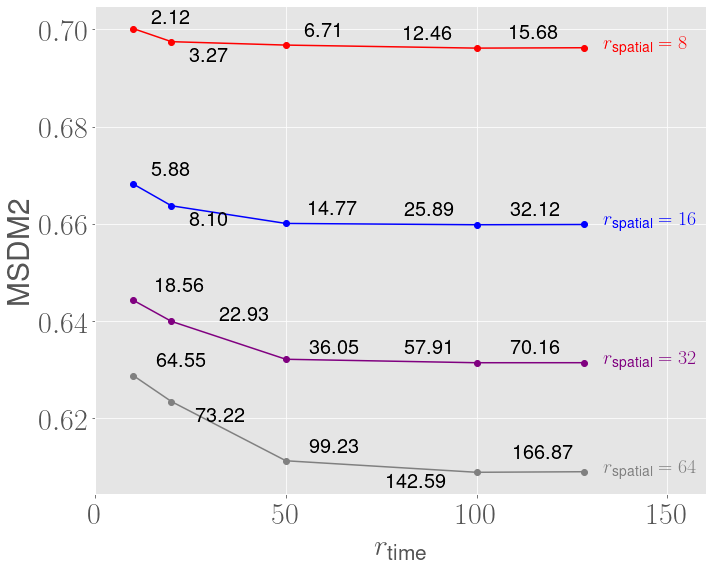

In [35]:
for key in metrics1.keys():
    fig = plt.figure(figsize=(10, 8))
    texts = []
    
    colors = ['grey', 'purple', 'blue', 'red']

    for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
        outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
        plt.plot(
            outer_ranks,
            metrics2[key][i], marker='o', color=colors[i])
        plt.text(
             outer_ranks[0] + 5,
             metrics2[key][i][0].item() if isinstance(metrics2[key][i][0], torch.Tensor) else metrics2[key][i][0],
             r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
             fontsize=20,
             color=colors[i])
        for j, k in enumerate(outer_ranks):
            t = ckpt2[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
            texts.append(
                plt.text(
                    k,
                    metrics2[key][i][j].item() if isinstance(metrics2[key][i][j], torch.Tensor) else metrics2[key][i][j],
                    f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                    fontsize=20))

    plt.xlabel(r'$r_{\text{time}}$', fontsize=30)
    plt.ylabel(key, fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.tick_params(axis='both', which='minor', labelsize=30)
    adjust_text(texts,
                expand_text=(2.05, 1.5),
                expand_points=(2.05, 1.5),
                expand_objects=(2.05, 1.5),
                expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
    plt.xlim(0, 160)
    plt.tight_layout()
    plt.savefig(f'../imgs/tt_{key}.pdf')
    plt.show()

# Renderings

In [5]:
coords = torch.tensor(
    torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/coords.pt')['coords'])

# TT-Tucker

In [81]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][8][10]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/lowres.png', jupyter_backend='none')

In [82]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][64][128]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/highres.png', jupyter_backend='none')

In [87]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = torch.load(files[i][0])['sdf']
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/original.png', jupyter_backend='none')

In [95]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][32][100]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/medres.png', jupyter_backend='none')

# QTT

In [2]:
ckpt = torch.load('../logs/sweeps/qtt_00032_longshort_flying_eagle_high_ranks_high_thr.pt')

In [3]:
scene = ckpt[(-0.05, 0.05)][400]['compressed_scene']

In [38]:
scene.round_tt(eps=0.5e-2)

In [41]:
rmax = 400
ranks_tt = scene.ranks_tt
ranks_tt[4::4] = torch.where(ranks_tt[4::4] < rmax, ranks_tt[4::4], rmax)
ranks_tt[3::4] = torch.where(ranks_tt[3::4] < rmax, ranks_tt[3::4], rmax)

lrs = tn.round_tt(scene.clone(), rmax=ranks_tt[1:-1])

In [45]:
scene.round_tt(rmax=2000)

In [49]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    qtt_framei = get_qtt_frame(lrs, i)
    framei = qtt2tensor3d(qtt_framei.torch())
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)
    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/qtt_lowres.png', jupyter_backend='none')

# TT

In [53]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][8][10]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_lowres.png', jupyter_backend='none')

In [54]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][64][128]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_highres.png', jupyter_backend='none')

In [58]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][32][100]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_medres.png', jupyter_backend='none')

In [61]:
ckpt2[(-0.05, 0.05)][8][10]['tensor'].numcoef() / ckpt2[(-0.05, 0.05)][8][10]['tensor'].numel() * 1000

tensor(0.0021, dtype=torch.float64)

In [62]:
512**3 * 284 * 64 / 8 / 2**20 * 0.0021 / 1000

0.6107136

# OQTT

In [6]:
ckpt = torch.load('../logs/sweeps/oqtt_00032_longshort_flying_eagle_ranks.pt')

In [7]:
ckpt[(-0.05, 0.05)][400]['compressed_scene'].numcoef() * 64 / 8 / 2**20

1786.7235107421875

In [11]:
compressed_frames = ckpt[(-0.05, 0.05)][400]['compressed_frames']

In [18]:
# [frame.to(torch.float32) for frame in compressed_frames]

In [19]:
scene2 = qtt_stack(compressed_frames, N=1, eps=1e-4, rank=4000, algorithm='eig')

In [60]:
scene2.round_tt(rmax=400)

In [61]:
scene2.numel() / scene2.numcoef()

tensor(10596.9491, dtype=torch.float64)

In [30]:
scene2.numcoef() * 32 / 8 / 2**30

1.246441587805748

In [62]:
def prep_fn(x, i):
    frame=get_qtt_frame(x, i, N=1)
    frame.round_tt(eps=1e-4)
    return oqtt2tensor3d(frame.torch())

compute_metrics(
    frames=[(osp.join(data_dir, 'meshes', model, scene, 'posed', frame),
             osp.join(data_dir, 'meshes', model, scene, 'posed', frame[4:-2] + 'obj'))
                for frame in frames],
    compressed_scene=scene2,
    preprocessing_fn=prep_fn,
    min_tsdf=-0.05,
    max_tsdf=0.05,
    num_sample_points=3000,
    sample_frames=[0, 142, 283])

  0%|                                                                                                                                                                                                                                 | 0/3 [00:07<?, ?it/s]

Marching cube started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:09<?, ?it/s]

Marching cube finished. Took: 2.257589101791382 s.
Marching cube started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:12<?, ?it/s]

Marching cube finished. Took: 2.249164342880249 s.
Sampling points started
Sampling points finished. Took: 0.1721785068511963 s.


  0%|                                                                                                                                                                                                                                 | 0/3 [00:12<?, ?it/s]

Voxelgrid conversion started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:26<?, ?it/s]

Voxelgrid conversion finished. Took: 13.975300312042236 s.


  0%|                                                                                                                                                                                                                                 | 0/3 [00:28<?, ?it/s]

hausdorff computation started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:29<?, ?it/s]

hausdorff computation finished. Took: 1.3765509128570557 s.
MSDM2 computation started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:28<12:57, 388.88s/it]

Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
MSDM2 computation finished. Took: 359.3790078163147 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:36<12:57, 388.88s/it]

Marching cube started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:39<12:57, 388.88s/it]

Marching cube finished. Took: 2.346980094909668 s.
Marching cube started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:41<12:57, 388.88s/it]

Marching cube finished. Took: 2.410259246826172 s.
Sampling points started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:41<12:57, 388.88s/it]

Sampling points finished. Took: 0.20653438568115234 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:42<12:57, 388.88s/it]

Voxelgrid conversion started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:59<12:57, 388.88s/it]

Voxelgrid conversion finished. Took: 17.326245307922363 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [07:00<12:57, 388.88s/it]

hausdorff computation started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [07:02<12:57, 388.88s/it]

hausdorff computation finished. Took: 1.5769338607788086 s.
MSDM2 computation started
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [12:31<06:13, 373.28s/it]

MSDM2 computation finished. Took: 328.7084171772003 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [12:39<06:13, 373.28s/it]

Marching cube started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [12:41<06:13, 373.28s/it]

Marching cube finished. Took: 2.2867679595947266 s.
Marching cube started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [12:44<06:13, 373.28s/it]

Marching cube finished. Took: 2.2804887294769287 s.
Sampling points started
Sampling points finished. Took: 0.17010974884033203 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [12:44<06:13, 373.28s/it]

Voxelgrid conversion started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [13:00<06:13, 373.28s/it]

Voxelgrid conversion finished. Took: 15.652898788452148 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [13:01<06:13, 373.28s/it]

hausdorff computation started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [13:02<06:13, 373.28s/it]

hausdorff computation finished. Took: 1.445410966873169 s.
MSDM2 computation started


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [18:37<00:00, 372.40s/it]

Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
MSDM2 computation finished. Took: 334.2695462703705 s.


{0: {'l2': tensor(5.6471),
  'chamfer_distance': tensor(0.0004, dtype=torch.float64),
  'IoU': tensor(0.0399),
  'hausdorff': 0.08351671512006786,
  'MSDM2': 0.4194992613112688},
 142: {'l2': tensor(8.5075),
  'chamfer_distance': tensor(0.0005, dtype=torch.float64),
  'IoU': tensor(0.2547),
  'hausdorff': 0.09539699635337001,
  'MSDM2': 0.48044256896865783},
 283: {'l2': tensor(8.5408),
  'chamfer_distance': tensor(0.0005, dtype=torch.float64),
  'IoU': tensor(0.1496),
  'hausdorff': 0.09617386371108394,
  'MSDM2': 0.4834779482814624}}

In [ ]:
def prep_fn(x, i):
    frame=x[..., i]
    frame.round_tt(rmax=2000)
    return oqtt2tensor3d(frame.torch())

compute_metrics(
    frames=[(osp.join(data_dir, 'meshes', model, scene, 'posed', frame),
             osp.join(data_dir, 'meshes', model, scene, 'posed', frame[4:-2] + 'obj'))
                for frame in frames],
    compressed_scene=scene1,
    preprocessing_fn=prep_fn,
    min_tsdf=-0.05,
    max_tsdf=0.05,
    num_sample_points=3000,
    sample_frames=[0, 142, 283])

In [40]:
def prep_fn(x, i):
    frame=x[..., i]
    frame.round_tt(eps=1e-4)
    return oqtt2tensor3d(frame.torch())

compute_metrics(
    frames=[(osp.join(data_dir, 'meshes', model, scene, 'posed', frame),
             osp.join(data_dir, 'meshes', model, scene, 'posed', frame[4:-2] + 'obj'))
                for frame in frames],
    compressed_scene=scene1,
    preprocessing_fn=prep_fn,
    min_tsdf=-0.05,
    max_tsdf=0.05,
    num_sample_points=3000,
    sample_frames=[0, 142, 283])

  0%|                                                                                                                                                                                                                                 | 0/3 [00:47<?, ?it/s]

Marching cube started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:48<?, ?it/s]

Marching cube finished. Took: 1.3568801879882812 s.
Marching cube started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:49<?, ?it/s]

Marching cube finished. Took: 1.2710363864898682 s.
Sampling points started
Sampling points finished. Took: 0.11740469932556152 s.


  0%|                                                                                                                                                                                                                                 | 0/3 [00:50<?, ?it/s]

Voxelgrid conversion started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:58<?, ?it/s]

Voxelgrid conversion finished. Took: 7.656863451004028 s.


  0%|                                                                                                                                                                                                                                 | 0/3 [00:58<?, ?it/s]

hausdorff computation started


  0%|                                                                                                                                                                                                                                 | 0/3 [00:59<?, ?it/s]

hausdorff computation finished. Took: 0.7416946887969971 s.
MSDM2 computation started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [05:17<10:35, 317.96s/it]

Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
MSDM2 computation finished. Took: 258.6824996471405 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:04<10:35, 317.96s/it]

Marching cube started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:05<10:35, 317.96s/it]

Marching cube finished. Took: 1.3508577346801758 s.
Marching cube started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:07<10:35, 317.96s/it]

Marching cube finished. Took: 1.2694990634918213 s.
Sampling points started
Sampling points finished. Took: 0.12091779708862305 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:07<10:35, 317.96s/it]

Voxelgrid conversion started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:15<10:35, 317.96s/it]

Voxelgrid conversion finished. Took: 8.206361770629883 s.


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:16<10:35, 317.96s/it]

hausdorff computation started


 33%|████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1/3 [06:17<10:35, 317.96s/it]

hausdorff computation finished. Took: 0.7845983505249023 s.
MSDM2 computation started
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [10:22<05:10, 310.19s/it]

MSDM2 computation finished. Took: 245.68488144874573 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:17<05:10, 310.19s/it]

Marching cube started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:19<05:10, 310.19s/it]

Marching cube finished. Took: 1.3529314994812012 s.
Marching cube started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:20<05:10, 310.19s/it]

Marching cube finished. Took: 1.2682275772094727 s.
Sampling points started
Sampling points finished. Took: 0.11582589149475098 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:21<05:10, 310.19s/it]

Voxelgrid conversion started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:28<05:10, 310.19s/it]

Voxelgrid conversion finished. Took: 7.861021041870117 s.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:29<05:10, 310.19s/it]

hausdorff computation started


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 2/3 [11:30<05:10, 310.19s/it]

hausdorff computation finished. Took: 0.7563507556915283 s.
MSDM2 computation started


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [15:56<00:00, 318.76s/it]

Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
Asking to calculate curvature
MSDM2 computation finished. Took: 266.1555597782135 s.


{0: {'l2': tensor(0.7933, dtype=torch.float64),
  'chamfer_distance': tensor(0.0004, dtype=torch.float64),
  'IoU': tensor(0.5802),
  'hausdorff': 0.015427598140506864,
  'MSDM2': 0.326324040069515},
 142: {'l2': tensor(0.9425, dtype=torch.float64),
  'chamfer_distance': tensor(0.0004, dtype=torch.float64),
  'IoU': tensor(0.8559),
  'hausdorff': 0.010351301815777111,
  'MSDM2': 0.2989634024804048},
 283: {'l2': tensor(0.6671, dtype=torch.float64),
  'chamfer_distance': tensor(0.0004, dtype=torch.float64),
  'IoU': tensor(0.8188),
  'hausdorff': 0.010208813685498601,
  'MSDM2': 0.28980148533996986}}

In [157]:
sdf66 = torch.load('/scratch2/data/ana/swing/meshes/')

In [158]:
tmeshi = sdf2mesh(sdf66['sdf'], torch.tensor(sdf66['coords']))

In [159]:
pos = tmeshi.vertices.copy()

In [192]:
pl = pv.Plotter()
# pl.camera_position = 'xy'
# pl.camera.elevation = -15
# pl.camera.roll = -15
# pl.camera.azimuth = -180
# # pl.camera.distance = 8
# # pl.camera.up = (-5, 10, 10)
# pl.camera.zoom(1.5)


# # tmeshi = sdf2mesh(sdf66['sdf'], torch.tensor(sdf66['coords']))
tmeshi.vertices = pos - np.array([2.5, 0.9, 0])
thetax = 50
thetay = 5
thetaz = 0
rotx = np.array([[1, 0, 0],
                 [0, np.cos(thetax), -np.sin(thetax)],
                 [0, np.sin(thetax), np.cos(thetax)]])
roty = np.array([[np.cos(thetay), 0, -np.sin(thetay)],
                 [0, 1, 0],
                 [np.sin(thetay), 0, np.cos(thetay)]])
rotz = np.array([[np.cos(thetaz), -np.sin(thetaz), 0],
                 [np.sin(thetaz), np.cos(thetaz), 0],
                 [0, 0, 1]])
tmeshi.vertices = tmeshi.vertices @ rotx @ roty @rotz
mesh = pv.wrap(tmeshi)

pl.add_mesh(mesh)
# pl.show(auto_close=True)
# image = pl.screenshot(None, return_img=True)
# pl.screenshot('../imgs/crane.pdf')
pl.show(screenshot=f'../imgs/samba.png', jupyter_backend='none')

In [86]:
image.max()

76

In [61]:
np.unique(res.ravel())

array([76], dtype=uint8)

In [31]:
512**3 * 284 / scene1.numcoef()

105.15542311472652

In [43]:
frame0_qtt.numcoef() * 64 / 8 / 2**20

2738.1422729492188

In [44]:
scene2.numcoef() * 32 / 8 / 2**30

1.246441587805748

In [45]:
scene2.numel() / scene2.numcoef()

tensor(205.3847, dtype=torch.float64)